<a href="https://colab.research.google.com/github/PriyankaDodeja/Flower_Image_Classifier/blob/main/flower_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 37.4 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

import time

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Loading Dataset

In [4]:
# # Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# Create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset['train'], dataset['validation'], dataset['test']

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

# Explore the Data

In [6]:
# Get the number of examples in each set from the dataset info.
total_num_examples = dataset_info.splits.total_num_examples
print('Number of examples :', total_num_examples)

# Get the number of classes in the dataset from the dataset info.
total_num_classes = dataset_info.features['label'].num_classes
print('Number of classes :', total_num_classes)


Number of examples : 8189
Number of classes : 102


In [7]:
num_training_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_testing_examples = dataset_info.splits['test'].num_examples

In [8]:
print(num_training_examples)
print(num_validation_examples)
print(num_testing_examples)

1020
1020
6149


In [9]:
# Print the shape and corresponding label of 3 images in the training set.
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image, label in training_set.take(3):
  image = image.numpy().squeeze()
  label = label.numpy()

  print('The label of this image is:', label)
  print('The shape of this image is:', image.shape)

The label of this image is: 72
The shape of this image is: (500, 667, 3)
The label of this image is: 84
The shape of this image is: (500, 666, 3)
The label of this image is: 70
The shape of this image is: (670, 500, 3)


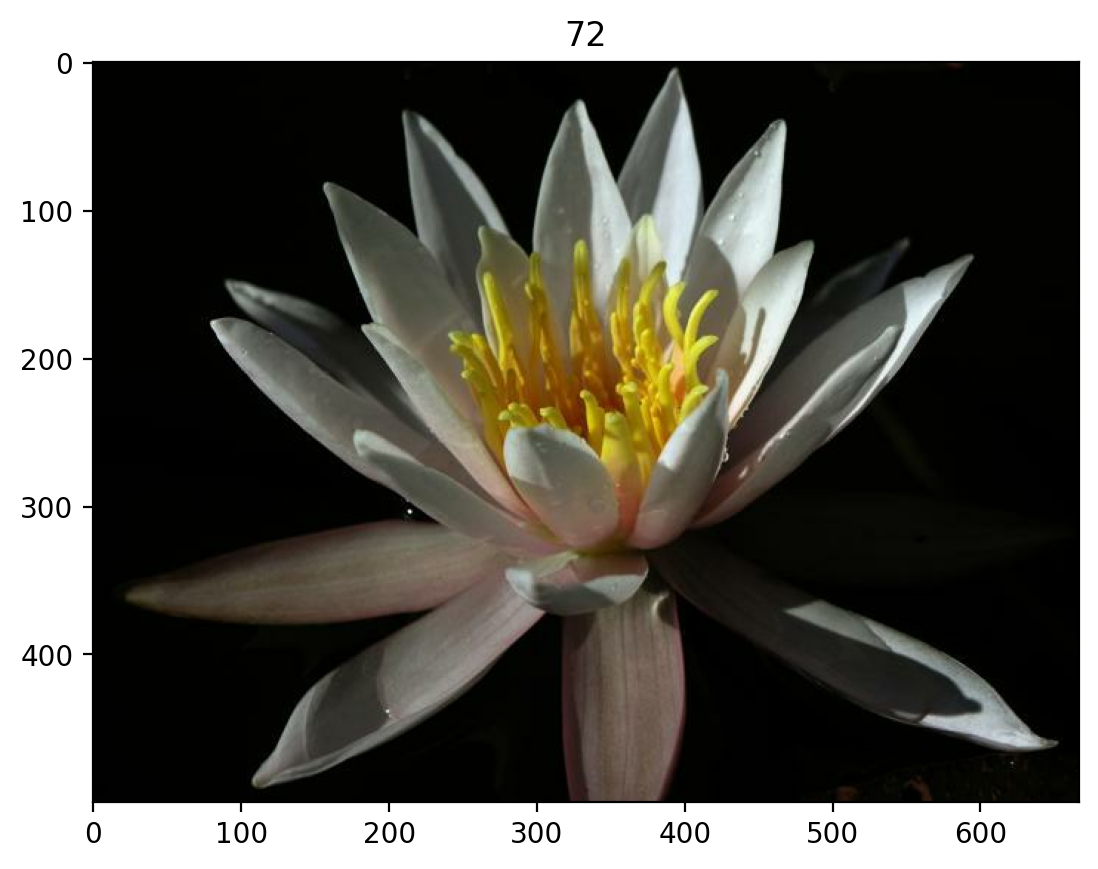

In [11]:
# Plot 1 image from the training set. Set the title
# of the plot to the corresponding image label.
for image, label in training_set.take(1):
  image = image.numpy().squeeze()
  label = label.numpy()
plt.imshow(image, cmap=plt.cm.binary)
plt.title(label)
plt.show()

# Label Mapping
You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
with open('/content/drive/MyDrive/dataset/image_classifier_data/label_map.json', 'r') as f:
  class_names = json.load(f)
print(class_names)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

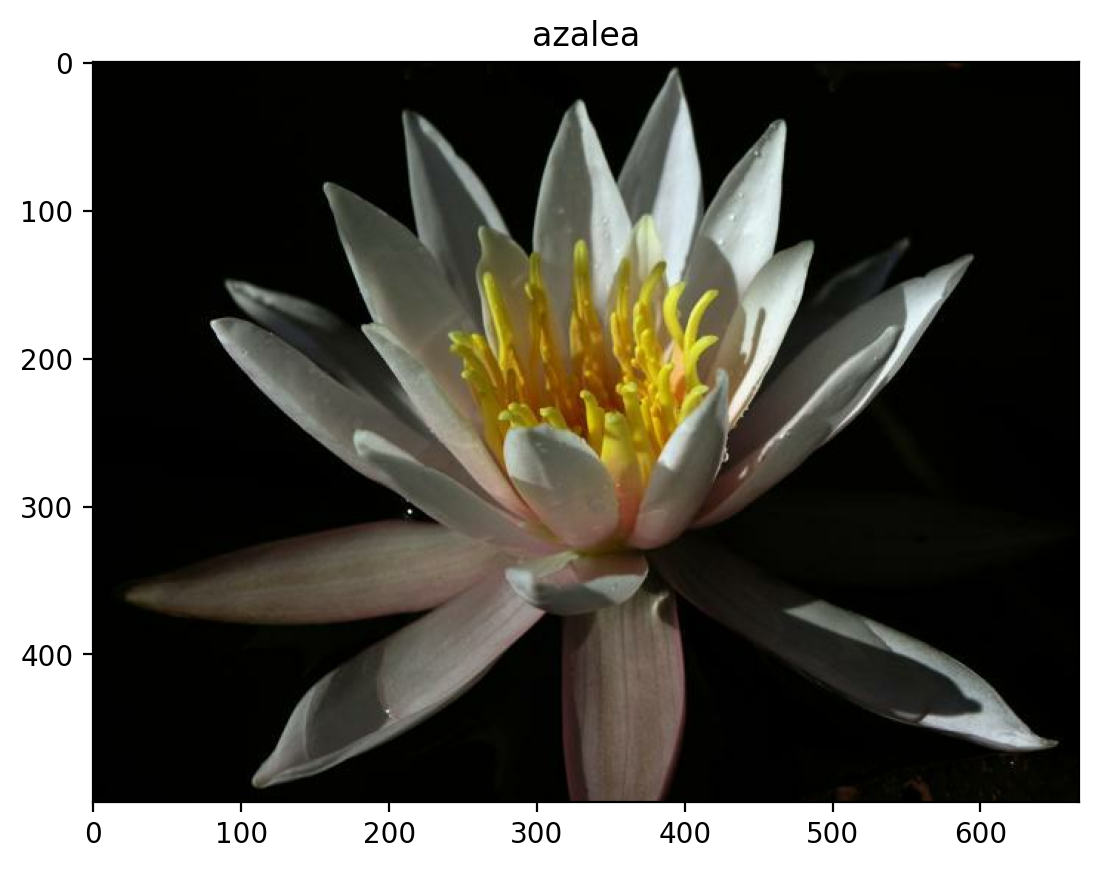

In [14]:
# Plot 1 image from the training set. Set the title
# of the plot to the corresponding class name.
for image, label in training_set.take(1):
  image = image.numpy().squeeze()
  label = label.numpy()

plt.imshow(image, cmap=plt.cm.binary)
plt.title(class_names[str(label)])
plt.show()

# Create Pipeline

In [15]:
shape_image = dataset_info.features['image'].shape
shape_image

(None, None, 3)

In [16]:
# Create a pipeline for each set.
batch_size = 64
image_size = 224

def format_image(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (image_size, image_size))
  image /= 255
  return image, label

training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model.

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [17]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size, 3))
feature_extractor.trainable = False

In [18]:
# Build and train your network.

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(total_num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Evaluating
loss, accuracy = model.evaluate(testing_batches)

print('\n Loss on TEST Set: {:.3f}'.format(loss))
print('Accuracy on TEST Set: {:.3%}'.format(accuracy))

97/97 [==============================] - 292s 3s/step - loss: 5.0625 - accuracy: 0.0163

 Loss on TEST Set: 5.062
Accuracy on TEST Set: 1.626%


In [20]:
EPOCHS = 30

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30
16/16 [==============================] - 134s 8s/step - loss: 4.4796 - accuracy: 0.0569 - val_loss: 3.6499 - val_accuracy: 0.2049
Epoch 2/30
16/16 [==============================] - 133s 8s/step - loss: 2.8192 - accuracy: 0.5127 - val_loss: 2.6398 - val_accuracy: 0.5294
Epoch 3/30
16/16 [==============================] - 131s 8s/step - loss: 1.7715 - accuracy: 0.8069 - val_loss: 2.0199 - val_accuracy: 0.6706
Epoch 4/30
16/16 [==============================] - 130s 8s/step - loss: 1.1582 - accuracy: 0.9196 - val_loss: 1.6577 - val_accuracy: 0.7275
Epoch 5/30
16/16 [==============================] - 130s 8s/step - loss: 0.8002 - accuracy: 0.9539 - val_loss: 1.4352 - val_accuracy: 0.7618
Epoch 6/30
16/16 [==============================] - 142s 9s/step - loss: 0.5887 - accuracy: 0.9735 - val_loss: 1.2931 - val_accuracy: 0.7735
Epoch 7/30
16/16 [==============================] - 128s 8s/step - loss: 0.4456 - accuracy: 0.9902 - val_loss: 1.1934 - val_accuracy: 0.7922
Epoch 8/30
16

In [21]:
# Check that history.history is a dictionary
print('history.history is of type: ', type(history.history))

# Print the keys of the history.history dictionary
print('The keys of history.history are: ', list(history.history.keys()))

history.history is of type:  <class 'dict'>
The keys of history.history are:  ['loss', 'accuracy', 'val_loss', 'val_accuracy']


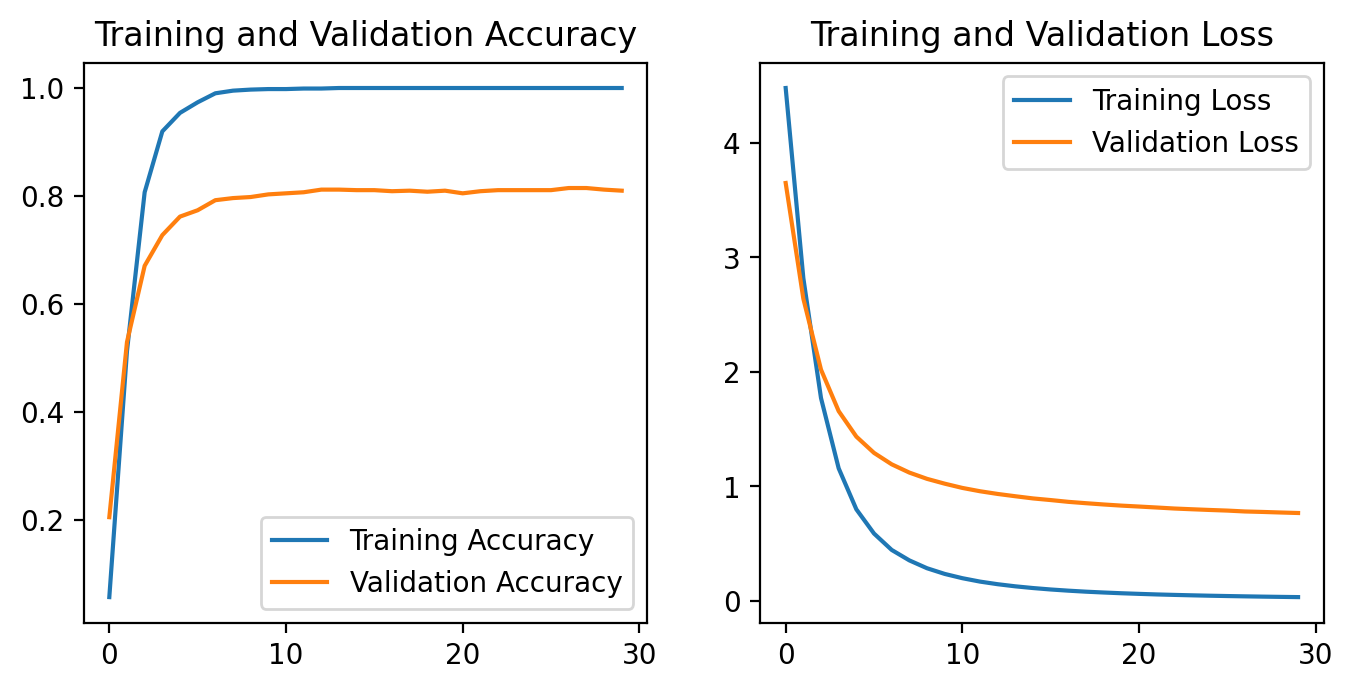

In [22]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [23]:
# Print the loss and accuracy values achieved on the entire test set.
# loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on TEST set: {:,.3f}'.format(loss))
print('Accuracy on TEST set: {:.3%}'.format(accuracy))
print(loss, accuracy)


Loss on TEST set: 5.062
Accuracy on TEST set: 1.626%
5.062481880187988 0.016262806951999664


# Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [24]:
# Save your trained model as a Keras model.
t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))

model.save(saved_keras_model_filepath)
print(saved_keras_model_filepath)

./1692863022.h5


# Load the Keras Model

Load the Keras model you saved above.

In [25]:
# Load the Keras Model

reload_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer': hub.KerasLayer})
reload_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function.

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values.

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [26]:
# Create the process_image function
def process_image(image):
    image = tf.convert_to_tensor(image,dtype = tf.float16)
    resized_im = tf.image.resize(image, (224, 224))

    pixels = resized_im/255.0

    return (pixels.numpy().squeeze())

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size.

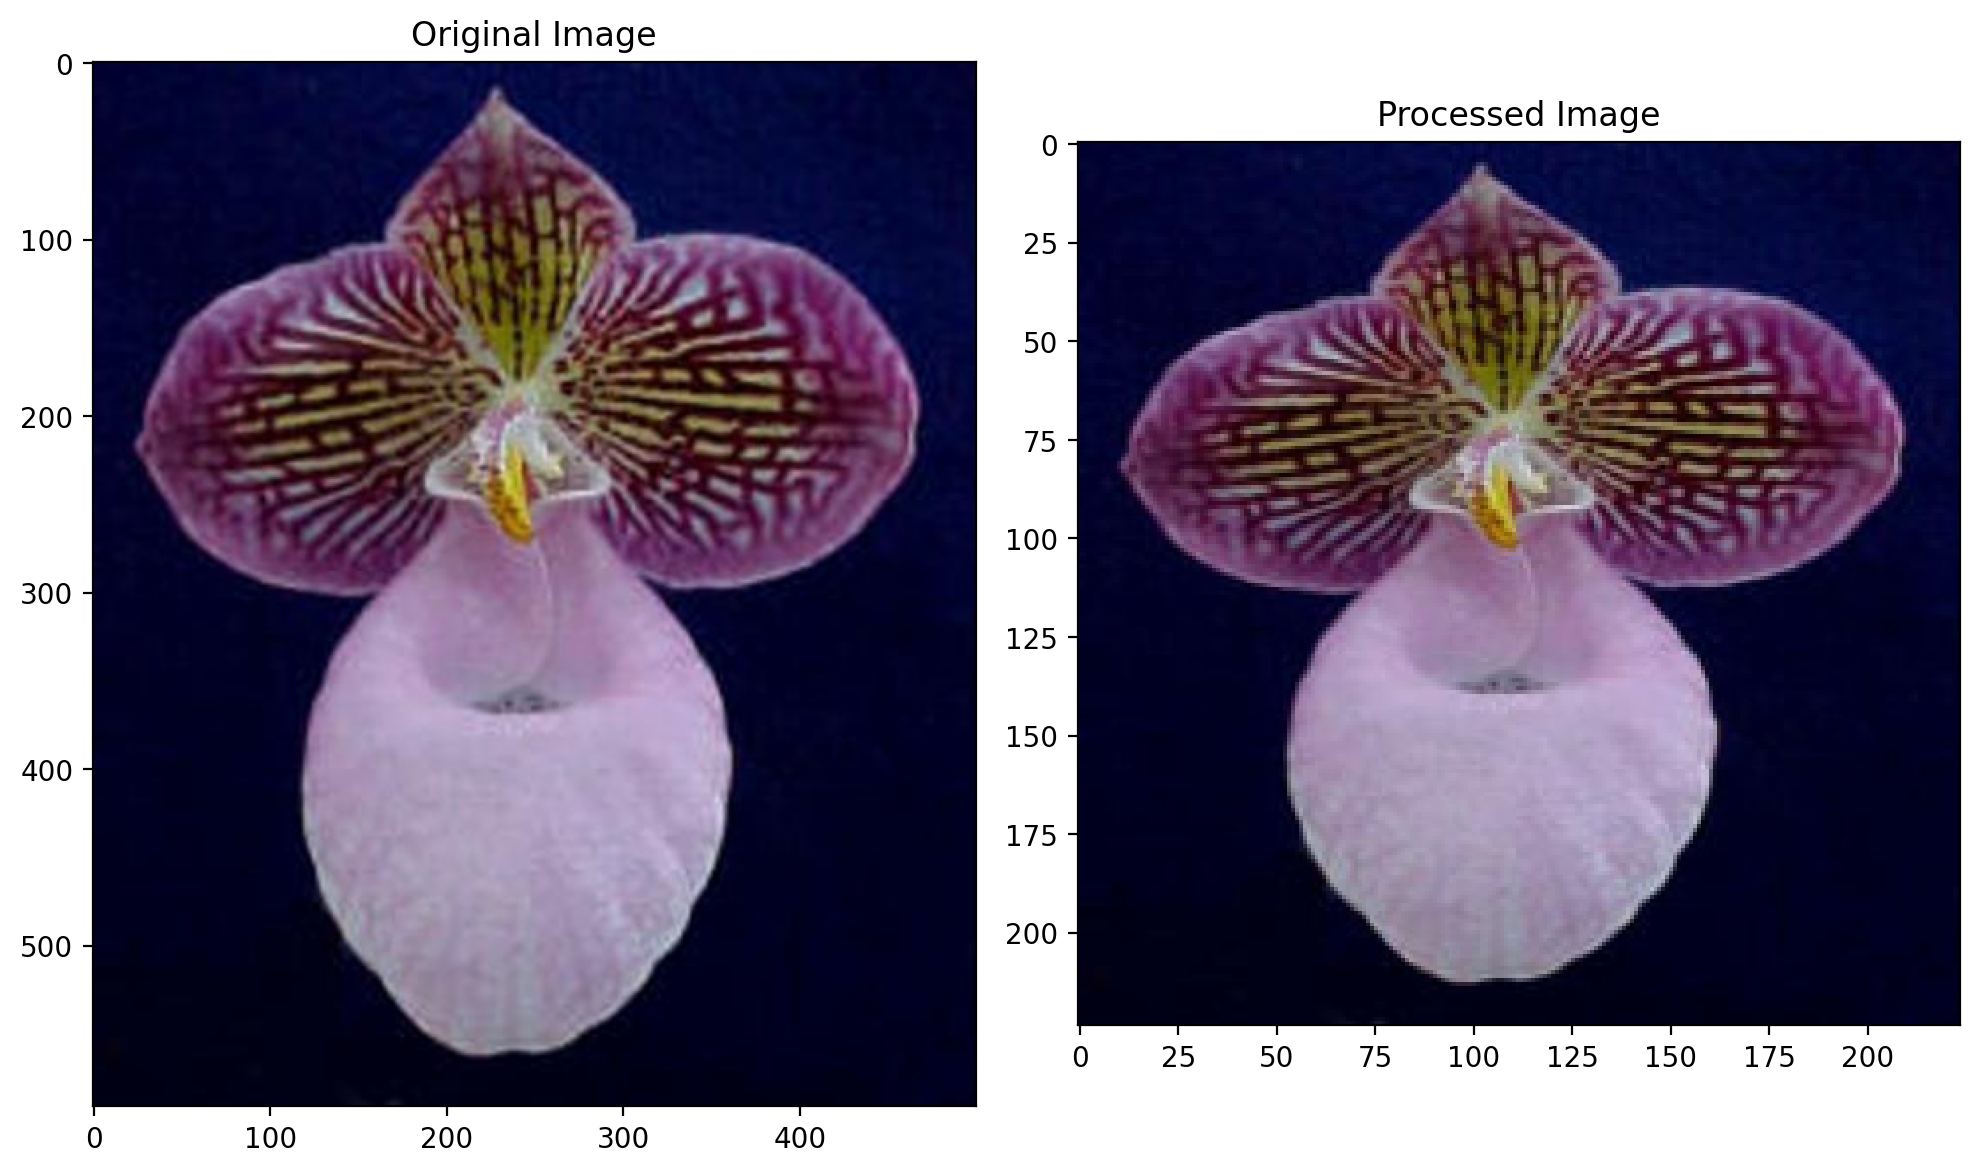

In [29]:
from PIL import Image

image_path = '/content/drive/MyDrive/dataset/image_classifier_data/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension.

In [30]:
image_path = '/content/drive/MyDrive/dataset/image_classifier_data/orange_dahlia.jpg'

In [33]:
# Create the predict function

def predict(image_path,model,top_k):
    im = Image.open(image_path)
    arr_im = np.asarray(im)

    processed_image = process_image(arr_im)

    processed_image = np.expand_dims(processed_image,axis = 0)
    pred = model.predict(processed_image)
    pred1, label = tf.nn.top_k(pred,k = top_k,sorted=True)

    probability = pred1[0].numpy().tolist()
    label = label[0].numpy().tolist()
    flowers = [class_names[str(x)] for x in label]

    return probability, label, flowers

predict(image_path,model,5)

1/1 [==============================] - 0s 60ms/step


([0.49505484104156494,
  0.18726882338523865,
  0.07851187884807587,
  0.04356781765818596,
  0.03982134163379669],
 [58, 4, 99, 65, 70],
 ['geranium', 'sweet pea', 'bromelia', 'californian poppy', 'tree poppy'])

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below, I use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<!-- <img src='assets/inference_example.png' width=600px> -->

You can convert from the class integer labels to actual flower names using `class_names`.

1/1 [==============================] - 0s 57ms/step


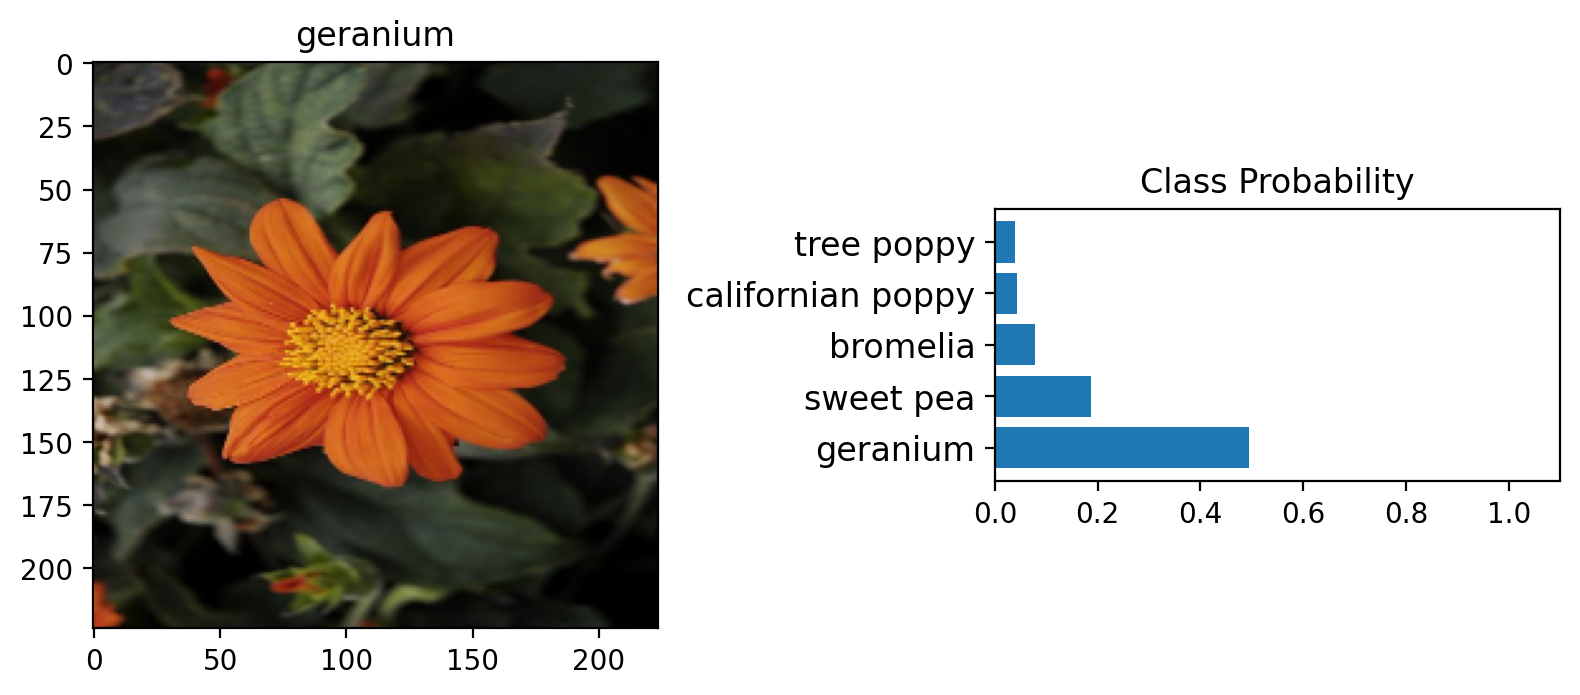

In [32]:
# Plot the input image along with the top 5 classes

top_k = 5

probs,classes, flowers = predict(image_path,model,top_k)

first_class = classes[0]

fir,(ax1,ax2) = plt.subplots(figsize=(8,12), ncols =2)
image = np.asarray(Image.open(image_path))
image = process_image(image)
ax1.imshow(image,cmap = plt.cm.binary)
#ax1.axis('off')
ax1.set_title(class_names[str(first_class)])

ax2.barh(np.arange(top_k),probs)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(top_k))
ax2.set_yticklabels([class_names[str(cls)] for cls in classes], size = 'large')
ax2.set_title('Class Probability')
ax2.set_xlim(0,1.1)
plt.tight_layout()